# interview solution

In [1]:
import os
import boto
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DOWNLOAD_LOCATION_PATH = os.path.expanduser('~')+'/Downloads/'

### Part1: Access to the data

In [3]:
bucket_name = 'stlz-dataengineer'
#access_key = os.environ['AWS_ACCESS_KEY'] # Does not need
#secret_access_key = os.environ['AWS_SECRET_ACCESS_KEY'] # Does not need
conn = boto.connect_s3()
my_bucket = conn.get_bucket(bucket_name)

In [4]:
b = my_bucket.get_key('interview-data/interview_data1')

In [5]:
# Uncomment only if you want to download the data again
#import time
#t0 = time.time()
#b.get_contents_to_filename(DOWNLOAD_LOCATION_PATH + 'test_data')
#t1 = time.time()
#print (t1-t0),'seconds'

### Part 2: Understand the data

##### 1. Load the data

In [6]:
CKEY = '17943e6c6eec49cdb6'

In [7]:
with open(DOWNLOAD_LOCATION_PATH + 'test_data','rb') as f:
    df = pd.read_json(f.read(),lines=True)
    df = df[df['ckey']==CKEY]

In [8]:
print 'Q1 Answer: ', df.shape[0], ' customers'

Q1 Answer:  157274  customers


In [9]:
print len(df['type'].unique()), 'log types'
print " , ".join(list(df['type'].unique()))

8 log types
vh , lBuf , mplyevent , Buf , upImg , iBuf , plyRdy , errmsg


##### 2. Drop the rows with 'tid' which do not have a meaningful value

In [10]:
# Keep only those columns
tmp_df = df[['uid','tid','tBuf','tIBuf','tLBuf','tPld','tVH','type','mplyevnt']]

In [11]:
# You may want to know what the unique 'tid's this data has
tid_lst = tmp_df['tid'].unique() 

In [12]:
tid_lst[:5] # hard to find manually, of course

array([u'08e784c7-ecc5-4012-8674-0847dfdef2d1',
       u'73ac11b1-153b-480a-8458-b90a3848c6a8',
       u'9d56503f-3e3a-4e4d-8d4f-8f9a1519c03e',
       u'd5272297-a471-4e2a-b9a2-d2db68345533',
       u'ac02efc1-6148-4018-b9ca-131eb66f8fc1'], dtype=object)

In [13]:
# You may use pandas.DataFrame.groupby; groupby 'tid' to see whether a group (with same 'tid') has same 'uid' or not.
# If the 'tid' has many 'uid's, then you've found one!
# This 'tid' does not look like other 'tid's
tid_grouped = tmp_df.groupby('tid') 

In [14]:
#let's see
i=0;
for tid in tid_lst:
    if tid_grouped.get_group(tid).apply(lambda x: min(x) == max(x))['uid']:
        i+=1;
    else: 
        print 'tid with different_uid: ',tid
print 'The number of tid with same uid: ',i
print 'The number of unique tid: ', len(tid_lst)
print 'Off by only 1, which is a tid = "Unset"'

tid with different_uid:  Unset
The number of tid with same uid:  5791
The number of unique tid:  5792
Off by only 1, which is a tid = Unset


In [15]:
# remove tid == Unset from the dataset
# Must find out which 'tid' has an unspecified 'uid' prior to do this operation
tmp_df_rmv_tid_Uns = tmp_df[tmp_df['tid']!='Unset']

##### 3. Now we start analyzing this data

In [16]:
print len(tmp_df['uid'].unique()),'unique users' 

1591 unique users


In [17]:
# Groupby uid
uid_grouped_rmv_tid_Uns = tmp_df_rmv_tid_Uns.groupby('uid')
uid_lst = uid_grouped_rmv_tid_Uns.groups.keys()

In [18]:
print len(uid_lst),'unique users' 
# Alternatively you can do this to get the number of unique users

1591 unique users


In [19]:
def get_tid_lst_frm_uid(uid_grouped_rmv_tid_Uns, uid):
    '''
    INPUT: Pandas DataFrame, groupby a uid
    OUTPUT: list, tids of a uid
    '''
    uid_tid_lst = []
    for tid in uid_grouped_rmv_tid_Uns.get_group(uid)['tid']:
        if tid not in uid_tid_lst:
            uid_tid_lst.append(tid)
    return uid_tid_lst

In [20]:
user_with_one_tid = [];
user_with_more_tids = [];
for uid in uid_lst:
    if len(get_tid_lst_frm_uid(uid_grouped_rmv_tid_Uns, uid)) == 1:
        user_with_one_tid.append(uid)
    else:
        user_with_more_tids.append(uid)
n1 = len(user_with_one_tid)
n2 = len(user_with_more_tids)
print 'The number of user with one tid: ',n1
print 'The number of user with more than one tids: ',n2
print 'The number of unique users = users with one tid + users with more than one tids ?',\
len(uid_lst) == n1 + n2

The number of user with one tid:  375
The number of user with more than one tids:  1216
The number of unique users = users with one tid + users with more than one tids ? True


##### 4. Draw a table

In [21]:
# Convert string into int
# For the time variables, such as tVH, etc..
def str_to_int_ftn(df, column_name):
    '''
    INPUT: Pandas DataFrame, string
    OUTPUT: Pandas DataFrame
    '''
    df[column_name] = df[column_name].fillna(0).astype(int)
    
str_to_int_lst = ['tPld','tIBuf','tBuf','tLBuf','tVH','drt']
for column_name in str_to_int_lst:
    str_to_int_ftn(df,column_name)

In [22]:
def get_sum_df(uid_grouped_rmv_tid_Uns,uid):
    '''
    INPUT: Pandas DataFrame, groupby uid
    OUTPUT: Pandas DataFrame, counted and summed by uid, tid
    '''
    uid_tid_grouped_rmv_tid_Uns = uid_grouped_rmv_tid_Uns.get_group(uid).groupby('tid')
    uid_tid_lst = get_tid_lst_frm_uid(uid_grouped_rmv_tid_Uns, uid)
    sum_lst=[]
    for tid in uid_tid_lst:
        tid_dict={}
        tid_dict['uid'] = uid
        tid_dict['tid'] = tid
        tid_dict['tBuf_sum'] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['tBuf'].sum()
        tid_dict['tIBuf_sum'] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['tIBuf'].sum()
        tid_dict['tLBuf_sum'] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['tLBuf'].sum()
        tid_dict['tPld_sum'] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['tPld'].sum()
        tid_dict['tVH_sum'] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['tVH'].sum()
        # Unzip the dictionary
        for key in uid_tid_grouped_rmv_tid_Uns.get_group(tid)['type'].value_counts().to_dict().keys():
            tid_dict['#type_'+ key] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['type'].value_counts().to_dict()[key]
        # Unzip the dictionary
        for key in uid_tid_grouped_rmv_tid_Uns.get_group(tid)['mplyevnt'].value_counts().to_dict().keys():
            tid_dict['#mplyevnt_'+key] = uid_tid_grouped_rmv_tid_Uns.get_group(tid)['mplyevnt'].value_counts().to_dict()[key]
        sum_lst.append(tid_dict)
    return pd.DataFrame(sum_lst)

In [23]:
Frame = []
for uid in uid_lst:
    Frame.append(get_sum_df(uid_grouped_rmv_tid_Uns,uid))
sum_df = pd.concat(Frame).fillna(0)

In [24]:
sum_df.iloc[:10,:]

,#mplyevnt_brchg,#mplyevnt_bufStart,#mplyevnt_compl,#mplyevnt_firstPlay,#mplyevnt_iBufStart,#mplyevnt_pause,#mplyevnt_play,#mplyevnt_stop,#type_Buf,#type_errmsg,...,#type_plyRdy,#type_upImg,#type_vh,tBuf_sum,tIBuf_sum,tLBuf_sum,tPld_sum,tVH_sum,tid,uid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,e51af90a-53f0-4af6-8122-bad1d0572d21,WUCH155102022
1,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,155940.0,b9bdec64-b541-42eb-9fb0-ffcaa36a69c3,WUCH155102022
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,21.0,0.0,0.0,0.0,0.0,1257156.0,820a40ef-0ddf-469f-8699-99fef4fd86e8,WUCH155102849
1,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,3.0,23.0,9217.0,0.0,0.0,0.0,1057136.0,381ecdf0-6924-46f9-a193-9de1047bf4f9,WUCH155102849
2,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,128123.0,8fd44d4c-2df2-4a87-9d2c-b595169fa74a,WUCH155102849
0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,4.0,27.0,0.0,0.0,0.0,0.0,1080311.0,1089ab63-9a8a-48c4-b313-0b1b50a161e5,WUCH155102025
0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,124.0,0.0,0.0,0.0,0.0,2319938.0,bb3683a7-db56-4cf2-a217-c559113601ad,WUCH155102028
0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,8223198.0,0.0,0a0242bd-dc7c-4ccb-af88-5ce778144e7d,WUCH155104324
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,68119.0,923fb2ae-3f9d-4f07-a34c-1d9a4dc35b75,WUCH155104324
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011.0,9df8101f-2e19-482e-a316-6b12e02074da,WUCH155104324


### Part 3: Descriptive statistics

##### 1. Find mean value, standard deviation, minimum value, maximum value for each column

In [25]:
sum_df.describe()

,#mplyevnt_brchg,#mplyevnt_bufStart,#mplyevnt_compl,#mplyevnt_firstPlay,#mplyevnt_iBufStart,#mplyevnt_pause,#mplyevnt_play,#mplyevnt_stop,#type_Buf,#type_errmsg,...,#type_lBuf,#type_mplyevent,#type_plyRdy,#type_upImg,#type_vh,tBuf_sum,tIBuf_sum,tLBuf_sum,tPld_sum,tVH_sum
count,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,...,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5.791000e+03,5.791000e+03,5.791000e+03
mean,4.302538,0.730962,0.158522,0.192886,0.089104,0.128475,0.734070,0.188914,1.439302,0.154032,...,8.126058,6.525471,0.070281,1.021240,9.179071,4375.070109,13.707304,4.063559e+04,3.186643e+05,3.592642e+05
std,12.944094,2.709570,0.365261,0.394598,0.300840,0.369010,2.682975,0.417520,5.697414,1.761349,...,58.079637,14.860898,0.255643,1.769165,16.135358,25281.486384,167.673734,2.905702e+05,4.221045e+06,5.316791e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,4.666800e+04
75%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.000000,0.000000,1.000000,13.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.957425e+05
max,166.000000,55.000000,1.000000,1.000000,2.000000,2.000000,54.000000,6.000000,57.000000,122.000000,...,533.000000,236.000000,1.000000,12.000000,199.000000,285298.000000,7588.000000,2.666875e+06,1.605290e+08,3.456049e+06


In [26]:
#=> each tid's distribution

##### 2. Plot histogram for columns 'tVH_sum'. Here, you can convert the time unit into 'minutes' if you want. 'tVH' is in milliseconds

In [27]:
def plotting_hist(column,exclude_zeros=False):
    '''
    INPUT: Pandas Series
    OUTPUT: histogram of the column
    '''
    if exclude_zeros:
        column[column>0].hist(alpha=0.5)
    else:
        column.hist(alpha=0.5)

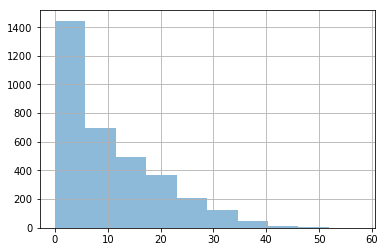

In [28]:
plotting_hist((sum_df['tVH_sum']/(1000*60)),True) # in minutes

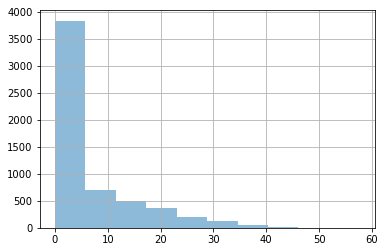

In [29]:
plotting_hist((sum_df['tVH_sum']/(1000*60)),False) # in minutes

##### 3. Draw one more table

In [30]:
uid_sum_df = sum_df.groupby('uid').sum()

In [31]:
uid_sum_df.iloc[:10,:]

,#mplyevnt_brchg,#mplyevnt_bufStart,#mplyevnt_compl,#mplyevnt_firstPlay,#mplyevnt_iBufStart,#mplyevnt_pause,#mplyevnt_play,#mplyevnt_stop,#type_Buf,#type_errmsg,...,#type_lBuf,#type_mplyevent,#type_plyRdy,#type_upImg,#type_vh,tBuf_sum,tIBuf_sum,tLBuf_sum,tPld_sum,tVH_sum
uid,,,,,,,,,,,,,,,,,,,,,
14110962300002,41.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,45.0,0.0,10.0,65.0,1604.0,6.0,0.0,0.0,2274435.0
14110962300011,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,20.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,1336024.0
14110962300012,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,4.0,15.0,0.0,293.0,0.0,0.0,800779.0
14110962300013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,16.0,0.0,0.0,0.0,0.0,909899.0
14110962300014,21.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,25.0,0.0,3.0,39.0,0.0,0.0,0.0,0.0,1432066.0
14110962300015,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.0,0.0,6.0,43.0,0.0,0.0,0.0,0.0,2526262.0
14110962300017,38.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,...,0.0,42.0,1.0,4.0,50.0,655.0,0.0,0.0,1827203.0,1635645.0
14110962300018,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,6.0,0.0,17.0,0.0,0.0,359312.0
14110962300019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,522.0,0.0,0.0,0.0,0.0,0.0,0.0,2612281.0,0.0,0.0


In [38]:
uid_sum_df.describe()

,#mplyevnt_brchg,#mplyevnt_bufStart,#mplyevnt_compl,#mplyevnt_firstPlay,#mplyevnt_iBufStart,#mplyevnt_pause,#mplyevnt_play,#mplyevnt_stop,#type_Buf,#type_errmsg,...,#type_lBuf,#type_mplyevent,#type_plyRdy,#type_upImg,#type_vh,tBuf_sum,tIBuf_sum,tLBuf_sum,tPld_sum,tVH_sum
count,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,...,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1.591000e+03,1.591000e+03,1.591000e+03
mean,15.660591,2.660591,0.576996,0.702074,0.324324,0.467630,2.671904,0.687618,5.238843,0.560654,...,29.577624,23.751728,0.255814,3.717159,33.410434,15924.595223,49.892520,1.479074e+05,1.159890e+06,1.307667e+06
std,29.647327,8.059555,0.815077,0.888353,4.195884,1.059869,8.202881,0.941612,12.568935,6.219866,...,108.037852,36.677645,4.233505,2.933725,31.720626,49172.341501,332.412906,5.405229e+05,1.018766e+07,8.583860e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.387470e+05
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,10.000000,0.000000,3.000000,27.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.333123e+06
75%,15.000000,2.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,3.000000,0.000000,...,0.000000,27.000000,0.000000,6.000000,43.000000,5005.500000,11.000000,0.000000e+00,0.000000e+00,2.035725e+06
max,253.000000,190.000000,7.000000,7.000000,164.000000,18.000000,200.000000,7.000000,208.000000,173.000000,...,533.000000,420.000000,165.000000,13.000000,267.000000,388052.000000,7588.000000,2.666875e+06,1.707998e+08,3.876611e+06


In [ ]:
#=> each uid's distribution

##### 4. Find the user who has maximum viewing time (i.e. the length of the viewing time). 
##### How long did the user watched? 'tVH' is in milliseconds, how long the viewing time in hour?

In [32]:
max_VH_user_df = uid_sum_df[uid_sum_df['tVH_sum']==uid_sum_df['tVH_sum'].max()]

In [33]:
max_VH_user_df

,#mplyevnt_brchg,#mplyevnt_bufStart,#mplyevnt_compl,#mplyevnt_firstPlay,#mplyevnt_iBufStart,#mplyevnt_pause,#mplyevnt_play,#mplyevnt_stop,#type_Buf,#type_errmsg,...,#type_lBuf,#type_mplyevent,#type_plyRdy,#type_upImg,#type_vh,tBuf_sum,tIBuf_sum,tLBuf_sum,tPld_sum,tVH_sum
uid,,,,,,,,,,,,,,,,,,,,,
WUCH155102425,10.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,...,0.0,15.0,1.0,2.0,23.0,0.0,0.0,0.0,3238402.0,3876611.0


In [34]:
max_VH_user_df['tVH_sum']/(1000*60)

uid
WUCH155102425    64.610183
Name: tVH_sum, dtype: float64

##### 5. Plot histogram for a column 'tVH'. Here, you can convert the time unit into 'minutes' if you want. 'tVH' is in milliseconds

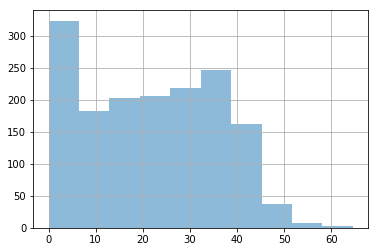

In [35]:
plotting_hist((uid_sum_df['tVH_sum']/(1000*60)),False) # in minutes

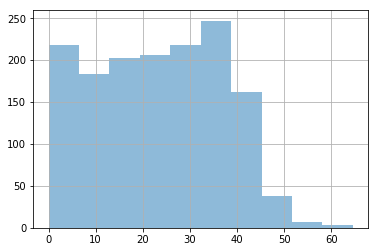

In [37]:
plotting_hist((uid_sum_df['tVH_sum']/(1000*60)),True) # in minutes

##### Optional

In [36]:
df['ts2'] # 11:56 pm ~ 01:20 am

0         2017-06-29T23:56:39.233Z
1         2017-06-29T23:57:38.902Z
2         2017-06-29T23:57:34.425Z
3         2017-06-29T23:55:42.740Z
4         2017-06-29T23:57:53.986Z
5         2017-06-29T23:57:35.872Z
6         2017-06-29T23:56:52.351Z
7         2017-06-29T23:55:05.633Z
8         2017-06-29T23:57:30.384Z
9         2017-06-29T23:58:15.590Z
10        2017-06-29T23:56:01.624Z
11        2017-06-29T23:57:37.646Z
12        2017-06-29T23:57:46.988Z
13        2017-06-29T23:57:54.469Z
14        2017-06-29T23:57:27.364Z
15        2017-06-29T23:56:40.221Z
16        2017-06-29T23:57:35.520Z
17        2017-06-29T23:57:06.327Z
18        2017-06-29T23:56:44.216Z
19        2017-06-29T23:57:38.151Z
20        2017-06-29T23:57:36.871Z
21        2017-06-29T23:54:32.412Z
22        2017-06-29T23:57:37.237Z
23        2017-06-29T23:57:39.532Z
24        2017-06-29T23:57:35.147Z
25        2017-06-29T23:55:59.824Z
26        2017-06-29T23:55:59.027Z
27        2017-06-29T23:54:51.707Z
28        2017-06-29